In [4]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import keras
import keras.backend as K
from tqdm import tqdm
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau, TensorBoard
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from mlxtend.plotting import plot_confusion_matrix
import cv2
import shutil
import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
from vis.utils import utils
from vis.visualization import visualize_cam

import warnings
warnings.filterwarnings("ignore")

print(tf.__version__)
print(keras.__version__)

1.13.1
2.2.4


In [6]:
model = load_model("../models/weights/model.h5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [13]:
def create_preprocessing_f(X, input_range=[0, 1]):
    """
    Generically shifts data from interval [a, b] to interval [c, d].
    Assumes that theoretical min and max values are populated.
    """
    if len(input_range) != 2:
        raise ValueError(
            "Input range must be of length 2, but was {}".format(
                len(input_range)))
    if input_range[0] >= input_range[1]:
        raise ValueError(
            "Values in input_range must be ascending. It is {}".format(
                input_range))

    a, b = X.min(), X.max()
    c, d = input_range

    def preprocessing(X):
        # shift original data to [0, b-a] (and copy)
        X = X - a
        # scale to new range gap [0, d-c]
        X /= (b-a)
        X *= (d-c)
        # shift to desired output range
        X += c
        return X

    def revert_preprocessing(X):
        X = X - c
        X /= (d-c)
        X *= (b-a)
        X += a
        return X

    return preprocessing, revert_preprocessing

1.0


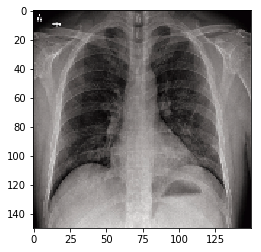

In [15]:
r = cv2.imread("../data/rob/nejmoa2001191_f5-PA.jpeg")
r = cv2.resize(r, (150, 150))

input_range = [0, 1]
r = r.astype("float")
preprocess, revert_preprocessing = create_preprocessing_f(r, input_range)

r = preprocess(r)
print(np.max(r))

plt.imshow(r)

In [20]:
y_pred = model.predict(r.reshape(-1, 150, 150, 3))
class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
class_idxs_sorted

array([2, 0, 1])

In [16]:
layer_idx = utils.find_layer_idx(model, 'concept')
# Swap softmax with linear
model.layers[layer_idx].activation = keras.activations.linear
model = utils.apply_modifications(model)

In [22]:
penultimate_layer_idx = utils.find_layer_idx(model, "block5_conv3") 
class_idx  = class_idxs_sorted[0]
seed_input = r
grad_top1  = visualize_cam(model, layer_idx, class_idx, seed_input, 
                           penultimate_layer_idx = penultimate_layer_idx,#None,
                           backprop_modifier     = None,
                           grad_modifier         = None)

In [27]:
def plot_map(grads, img):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(img)
    axes[1].imshow(img)
    i = axes[1].imshow(grads,cmap="jet",alpha=0.8)
    fig.colorbar(i)

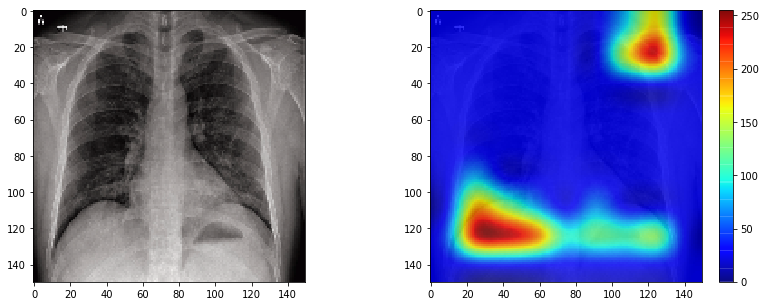

In [28]:
plot_map(grad_top1, r)